In [ ]:
#목표 : 모바일 게임의 고객 로그 데이터 분석해서 고객 유지율을 높임. (Kaggle의 AB Test 데이터사용)
#문제 정의 : 게임에서 특정 스테이지부터 Lock 된는데, 몇 번째 스테이지에서 할때 이용자 retention에 가장 좋을지 판단
#결론 : 카이제곱 독립검정의 유의확률을 통해,7일 뒤 retention 유지를 위해 게이트 30에 유지해야한다. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df =pd.read_csv('C:/Users/hongm/Downloads/cookie_cats.csv')

print(df.shape)
df.info()
df.head()

(90189, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


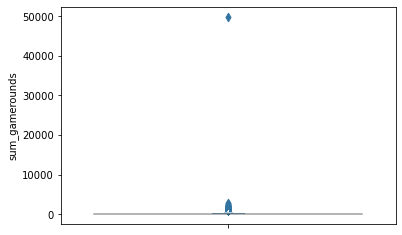

In [4]:
sns.boxenplot(data=df, y="sum_gamerounds")

#확실한 아웃라이어가 있음, 하지만 데이터가 편향된 데이터 분포임

In [6]:
df= df[df['sum_gamerounds'] < 45000]
print(df.shape)
df.head()

(90188, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [7]:
df['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

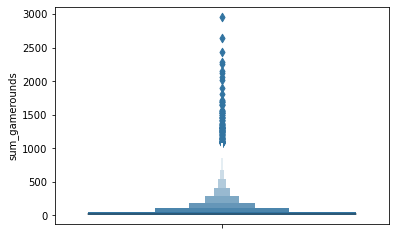

In [8]:
sns.boxenplot(data=df, y = "sum_gamerounds")

In [9]:
#각 게임실행 횟수 별 유저의 수를 카운트 

plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
2251       1
2294       1
2438       1
2640       1
2961       1
Name: userid, Length: 941, dtype: int64

Text(0.5, 0, '# Game rounds')

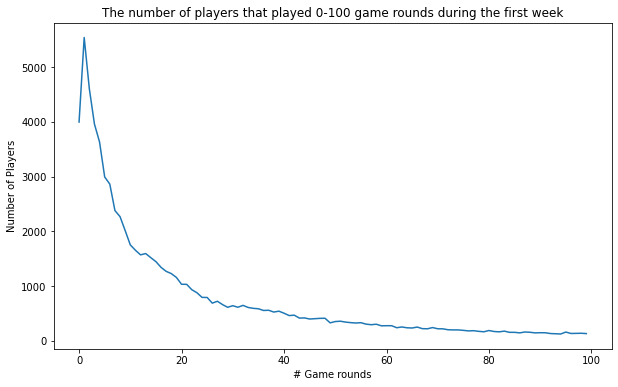

In [10]:
%matplotlib inline
ax= plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel('Number of Players')
ax.set_xlabel('# Game rounds')

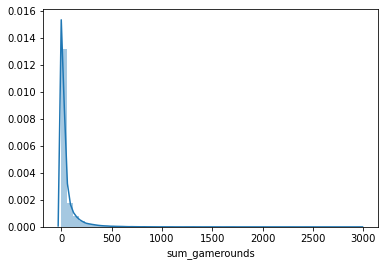

In [11]:
sns.distplot(df['sum_gamerounds'])
#result = 게임을 설치하고도 한 번도 실행하지 않은 유저 수가 많음. 

In [12]:
print(df['retention_1'].mean())
print(df['retention_7'].mean())

0.4452144409455803
0.1860557945624695


In [13]:
df.groupby('version')[('retention_1','retention_7')].mean()

C:\Users\hongm\anaconda3\envs\ck\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,retention_1,retention_7
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000


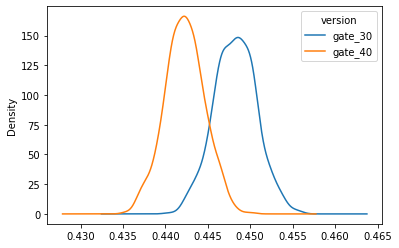

In [14]:
#bootstrapping 두 그룹간의 차이의 유의미

boot_1d =[]
for i in range(1000):
    boot_mean = df.sample(frac =1, replace =True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)

#부트스트랩 분포에 대한 Kernel Density Estimate plot

boot_1d.plot(kind='density')

게이트가 레벨 30에 있을 때 1- day retention 이 클 확률: 0.962


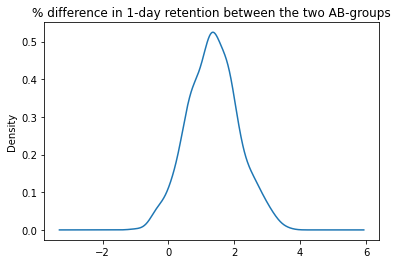

In [18]:
# 두 AB 그룹간의 % 차이 평균 컬럼 추가
boot_1d['diff'] =(boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# bootstrap % 차이 시각화
ax =boot_1d['diff'].plot( kind ='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')
 
print('게이트가 레벨 30에 있을 때 1- day retention 이 클 확률:', (boot_1d['diff']> 0 ).mean())

In [21]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

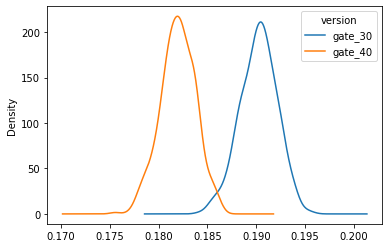

In [26]:
boot_7d =[]
for i in range(500):
    boot_mean = df.sample(frac =1, replace =True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

#부트스트랩 분포에 대한 Kernel Density Estimate plot

boot_7d.plot(kind='density')


게이트가 레벨 30에 있을 때 7- day retention 이 클 확률: 1.0


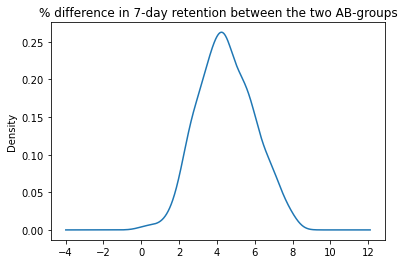

In [24]:
boot_7d['diff'] =(boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# bootstrap % 차이 시각화
ax =boot_7d['diff'].plot( kind ='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')
 
print('게이트가 레벨 30에 있을 때 7- day retention 이 클 확률:', (boot_7d['diff']> 0 ).mean())

#즉 retiontion을 늘리기 위해 게이트 레벨을 40으로 이동하면 안된다. 

In [27]:
#T_test 
df_30 = df[df['version'] == 'gate_30']
print(df_30.shape)
df_30.tail()

(44699, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90179,9998576,gate_30,14,True,False
90180,9998623,gate_30,7,False,False
90182,9999178,gate_30,21,True,False
90183,9999349,gate_30,10,False,False
90186,9999710,gate_30,28,True,False


In [28]:
df_40 = df[df['version'] == 'gate_40']
print(df_40.shape)
df_40.tail()

(45489, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90181,9998733,gate_40,10,True,False
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [33]:
#독립표본 T_test (2 Sample T -Test) 

from scipy import stats 

tTestResult = stats.ttest_ind(df_30['retention_1'], df_40['retention_1'])

tTestResultDiffVar = stats.ttest_ind(df_30['retention_1'], df_40 ['retention_1'], equal_var = False)

tTestResult

Ttest_indResult(statistic=1.7871153372992439, pvalue=0.07392220630182521)

In [34]:
tTestResult = stats.ttest_ind(df_30['retention_7'], df_40['retention_7'])

tTestResultDiffVar = stats.ttest_ind(df_30['retention_7'], df_40 ['retention_7'], equal_var = False)

tTestResult

#사실 이런 0,1의 데이터로 t-test를 하는것은 적정하지 않다, 

Ttest_indResult(statistic=3.1575495965685936, pvalue=0.0015915357297854773)

In [35]:
# 분할표를 만들기 위한 버전별 생존자 수 합계
df.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222937707836,2294941,20034.0,8501.0
gate_40,227857702576,2333530,20119.0,8279.0


In [36]:
df.groupby('version').count()


,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44699,44699,44699,44699
gate_40,45489,45489,45489,45489


In [37]:
import scipy as sp

obs1 = np.array([[20119, (45489-20119)],[20034, (44699-20034)]])

In [38]:
obs7 = np.array([[8501, (44699-8501)],[8279, (45489-8279)]])
sp.stats.chi2_contingency(obs7)

#카이제곱 독립검정의 유의확률은 .01%로 X ,Y는 상관간계가 있다고 말할 수 있다. 

(9.915275528905669,
 0.0016391259678654423,
 1,
 array([[ 8316.50796115, 36382.49203885],
        [ 8463.49203885, 37025.50796115]]))

In [ ]:
# 결론적으로 gate를 30에 두고 유지해야한다.

#하지만, retention 이외에 고려해야할 메트릭스로는 
#(앱내 구매, 게임 플레이 횟수, 친구초대로 인한 referrer)등으로 두어 기획자 차원에서 정말 중요한 메트릭을 저하고 그 기준으로 평가하는 것이 중요하다. 